# Principal Component Analysis (PCA)

En esta notebook se implementa el algoritmo de PCA usando la perspectiva de proyección. Primero se implementa PCA, luego lo aplicamos al conjunto de datos MNIST. 

## Learning objectives

1. Escribir el código que implementa PCA. 
2. Escribir codigo que implementa PCA para high-dimensional datasets. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml  # before fetch_mldata: needed to import the minst dataset

## Data

In [2]:
images, labels = fetch_openml("mnist_784",  # 28x28 mnist dataset 
                              version=1,
                              return_X_y=True,
                              as_frame=False)  # Data is returned as a np array

### EDA

In [3]:
type(images)

numpy.ndarray

In [4]:
images.shape

(70000, 784)

In [5]:
print('Total of images: ', images.shape[0])
print('Size of images (28 x 28): ', images.shape[1])

Total of images:  70000
Size of images (28 x 28):  784


In [6]:
print("D = ", images.shape[1])
print("M = ", images.shape[0])

D =  784
M =  70000


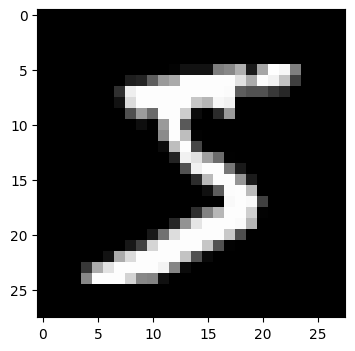

In [7]:
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(28,28), cmap='gray')

In [8]:
type(labels)

numpy.ndarray

In [9]:
type(labels[0])

str

In [11]:
print('The 0 label must be a 5 -> ', labels[0], int(labels[0]) == 5)

The 0 label must be a 5 ->  5 True


###  Data preprocessing

1. Normalizar los datos (cada pixel debe estar entre 0 y 1). 
2. Substraer de cada imagen $\mu$. 
3. Escalar cada imagen por $1/\sigma$. 

In [12]:
# images.mean(axis=0)

In [13]:
# images.std(axis=0)

In [14]:
# images.max(axis=0)

In [15]:
def normalize_images(X: np.ndarray, NUM_DATAPOINTS: int): 
    """
    Normalize the set of images. 
    """ 
    X_n = (X.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.0
    return X_n

In [18]:
nimages = normalize_images(images, 1000)  # We use a total of 1000 images from the original dataset

In [19]:
nimages.shape

(1000, 784)

In [20]:
nimages[0].min()

np.float64(0.0)

In [21]:
nimages[0].max()

np.float64(1.0)

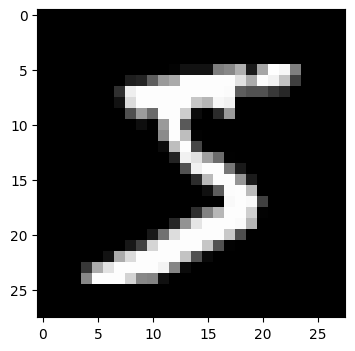

In [22]:
plt.figure(figsize=(4,4))
plt.imshow(nimages[0].reshape(28, 28), cmap='gray')

In [30]:
def estandarize_data(X: np.ndarray):
    """
    Estandarize the given dataset X. 
    """ 
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    std_filled = std.copy()
    std_filled[std == 0] = 1.0
    X_b = ((X - mu) / std_filled)
    return X_b, mu, std

In [31]:
nimages.mean(axis=0).max()

np.float64(0.544407843137255)

In [32]:
nimages.std(axis=0).max()

np.float64(0.44936752666984614)

In [33]:
X_b, mu, std = estandarize_data(nimages)

In [34]:
print(X_b.max())
print(X_b.min())

31.606961258558233
-1.2791422420460479


## PCA 

En las siguientes celdas se implementa PCA. 
Asumimos que ejecutamos PCA en un dataset $\textbf{X}$ para $\textbf{M}$ componentes principales. Una vez normalizados los datos, lo siguiente es encontrar los eigenvectores (principal components) y los eigenvalores para la matriz de covarianza $\textbf{S}$. Estos eigenvalores deben ordenarse de mayor a menor con sus respectivos eigenvectores. 

Después de esto, podemos computar la proyección y la reconstruccion de los datos originales en el espacio generado por los $n$ eigenvalores más significativos. 

In [35]:
arr = np.array([[1, 2], [2, 5]])

In [36]:
eigvals, eigvecs = np.linalg.eig(arr)

In [ ]:
a = np.array([3, 1, 2])
print("descending indexes: ", np.argsort(a))
print("ascending", np.argsort(a)[::-1])

descending indexes:  [1 2 0]
ascending [0 2 1]


In [38]:
k = np.argsort(eigvals)[::-1]
print(k)

[1 0]


In [39]:
print("Unsorted")
print(eigvals)
print(eigvecs)

Unsorted
[0.17157288 5.82842712]
[[-0.92387953 -0.38268343]
 [ 0.38268343 -0.92387953]]


In [40]:
print("Sorted")
seigvals = eigvals[k]
seigvecs = eigvecs[:, k]
print(seigvals)
print(seigvecs)

Sorted
[5.82842712 0.17157288]
[[-0.38268343 -0.92387953]
 [-0.92387953  0.38268343]]


In [42]:
def eig(S: np.ndarray): 
    """
    Compute the eigenvalues and eigenvectors
    for the covariance matrix S. 
    """
    eigvals, eigvecs = np.linalg.eig(S)
    idx = np.argsort(eigvals)[::-1]
    return eigvals[idx], eigvecs[:, idx]


In [43]:
# https://en.wikipedia.org/wiki/Projection_matrix
def projection_matrix(B: np.ndarray): 
    """
    Compute the projection matrix onto the space spanned by B.
    """
    return (B @ np.linalg.inv(B.T @ B)) @ B.T

In [44]:
# Testing the projection_matrix function
A = np.array([[1, -1], [2, 3], [3, 4]])  # Basis of the plane -x+7y + 5z = 0
P = projection_matrix(A)
x = np.array([[0, 0, 5]]).reshape(3, -1)

In [45]:
print("Proj_P(X): \n", P @ x)

Proj_P(X): 
 [[0.33333333]
 [2.33333333]
 [3.33333333]]


In [47]:
def PCA(X: np.ndarray, ncomponents: int):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """
    # Compute the covariance matrix S
    S = 1.0 / len(X) * (X.T @ X)

    # Find the eigenvalues and correspondig eigenvectors for S
    eig_vals, eig_vecs = eig(S)

    # Take the n principal components
    eig_vals, eig_vecs = eig_vals[:ncomponents], eig_vecs[:, :ncomponents]

    B = np.real(eig_vecs)  # Principal component matrix

    # Reconstruction of the original data
    reconst = projection_matrix(B) @ X.T
    return reconst.T

### PCA for high-dimensional datasets $\left(N\ll D\right)$

En ocasiones, la dimensión del dataset es mucho más grande que el total de muestras $\left(N\ll D\right)$, por lo que conviene actualizar el algortimo anterior. Podemos implementar PCA de manera eficientesiguiendo los siguienes pasos: 

1. Calcular la matriz $\boldsymbol X\boldsymbol X^T$ ($\boldsymbol X\in \mathbb{R}^{D\times N}$, con $N \ll D$)
2. Calcular los eigenvalores $ \lambda_i$ y los eigenvectores (principal components) $v_i$ de $\boldsymbol X\boldsymbol X^T$
3. Calcular los eigengectores para la matriz de covarianza original como $\boldsymbol X^T\boldsymbol V$. Elegir los vectores propios asociados con los M mayores valores propios para que sean la base del subespacio principal $\boldsymbol U$.
4. Calcular la proyección ortogonal de los datos sobre el subespacio generado por las columnas de $\boldsymbol U$.


In [ ]:
def PCA_high_dim(X: np.ndarray, ncomponents: int): 
    """
    Compute PCA for small sample size but high-dimensional features. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the sample,
           and N is the number of samples
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` pricipal components
    """
    N, D = X.shape
    M = np.dot(X, X.T) / N
    eig_vals, eig_vecs = eig(M)
    eig_vals, eig_vecs = eig_vals[:ncomponents], eig_vecs[:, :ncomponents]
    U = (X.T @ (eig_vecs))
    reconst = np.zeros((N, D))
    reconst = ((U @ np.linalg.inv(U.T @ U) @ U.T) @ X.T).T
    return answer

In [57]:
print(np.testing.assert_almost_equal(PCA(X_b, 2), PCA_high_dim(X_b, 2)))

None


## Evalueate results

In [ ]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [ ]:
loss = []
reconstructions = []

# Iterate over different number of principal components, and compute MSE
for num_component in range(1, 100): 
    reconst = PCA(X_b, num_component)
    error = mse(X_b, reconst)
    reconstructions.append(reconst)
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu  # 'de-normalize' the reconstructed image
loss = np.asarray(loss)

In [ ]:
plt.Figure(figsize=(10, 10))
plt.plot(loss[:, 0], loss[:, 1], label='MSE')
plt.axhline(100, linestyle='--', color='r', label='# components')
plt.xticks(np.arange(1, 100, 5))
plt.xlabel('num_components')
plt.ylabel('MSE')
plt.title('MSE vs number of principal components')
plt.grid()

Entre más componentes principales usamos para la reconstrucción, menor es el MSE. 

In [ ]:
from ipywidgets import interact

### Functions for plotting the reconstruction of the digits

In [ ]:
@interact(image_idx=(0, 999))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(50, 50))
    actual = X_b[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(0, 109, 11)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

In [ ]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X_b[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.axis('off')
    plt.show()